In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics

from TorchTemplates import SimpleBinaryClassificationNN as sbcnn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, ConfusionMatrixDisplay, classification_report
from scipy.stats import ks_2samp
from operator import itemgetter

In [2]:
df = pd.read_csv(r'C:/Users/User/Desktop/credit card/creditcard.csv').drop(columns=['Time'])

train_val, test = train_test_split(df, test_size=.15, stratify=df['Class'])
train, val = train_test_split(train_val, test_size=.2, stratify=train_val['Class'])

In [5]:
print(train.shape, val.shape, test.shape)
for i in (train, val, test):
    print(i['Class'].value_counts(normalize=True))

(193668, 30) (48417, 30) (42722, 30)
0    0.998275
1    0.001725
Name: Class, dtype: float64
0    0.998265
1    0.001735
Name: Class, dtype: float64
0    0.998268
1    0.001732
Name: Class, dtype: float64


In [6]:
target = 'Class'

X_train = train[train.columns.drop(target)]
X_val = val[val.columns.drop(target)]
X_test = test[test.columns.drop(target)]

y_train = train[target]
y_val = val[target]
y_test = test[target]

train_loader, scaler = sbcnn.make_loader(X_train, y_train, shuffle=True, batch_size=2048, fit_scaler=True, scaler=StandardScaler)
val_loader = sbcnn.make_loader(X_val, y_val, X_val.shape[0], scaler=scaler)
test_loader = sbcnn.make_loader(X_test, y_test, X_test.shape[0], scaler=scaler)

sbcnn.layer_template()


{
'input': {'units':[None,None], 'batch_norm': None, 'dropout': None, 'activation': None},
'fcn'  : {'units':[None,None], 'batch_norm': None, 'dropout': None, 'activation': None},
'output':{'units':[None,None], 'batch_norm': None, 'dropout': None, 'activation': None}
}



In [22]:
model = sbcnn({
'input':  {'units':[29,32], 'batch_norm': True, 'dropout': 0.5, 'activation': 'ReLU'},
'fc1'  :  {'units':[32,8], 'batch_norm': True, 'dropout': 0.3, 'activation': 'ReLU'},
'output': {'units':[8,1], 'batch_norm': None, 'dropout': 0.0, 'activation': None}
},
l1_lambda=0.01,
l2_lambda=0.01,
scaler=scaler,
l1_not_applied=('bias','bn'),
l2_not_applied=('bias'))

lossfun = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(7))
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [23]:
model.fit(lossfun=lossfun,
          optimizer=optimizer,
          train_loader=train_loader,
          test_loader=val_loader,
          epochs=100,
          early_stop=5)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


epoch 0 - train AUROC: 0.899 | test AUROC: 0.970
epoch 1 - train AUROC: 0.916 | test AUROC: 0.970
epoch 2 - train AUROC: 0.948 | test AUROC: 0.955
epoch 3 - train AUROC: 0.948 | test AUROC: 0.973
epoch 4 - train AUROC: 0.938 | test AUROC: 0.975
epoch 5 - train AUROC: 0.964 | test AUROC: 0.985
epoch 6 - train AUROC: 0.940 | test AUROC: 0.988
epoch 7 - train AUROC: 0.941 | test AUROC: 0.978
epoch 8 - train AUROC: 0.951 | test AUROC: 0.974
epoch 9 - train AUROC: 0.962 | test AUROC: 0.974
epoch 10 - train AUROC: 0.984 | test AUROC: 0.976
epoch 11 - train AUROC: 0.984 | test AUROC: 0.979
no improvement for 5 epochs, early stop


In [24]:
X, y = next(iter(test_loader))
pred_test = torch.sigmoid(model(X)).detach().numpy().reshape(-1)

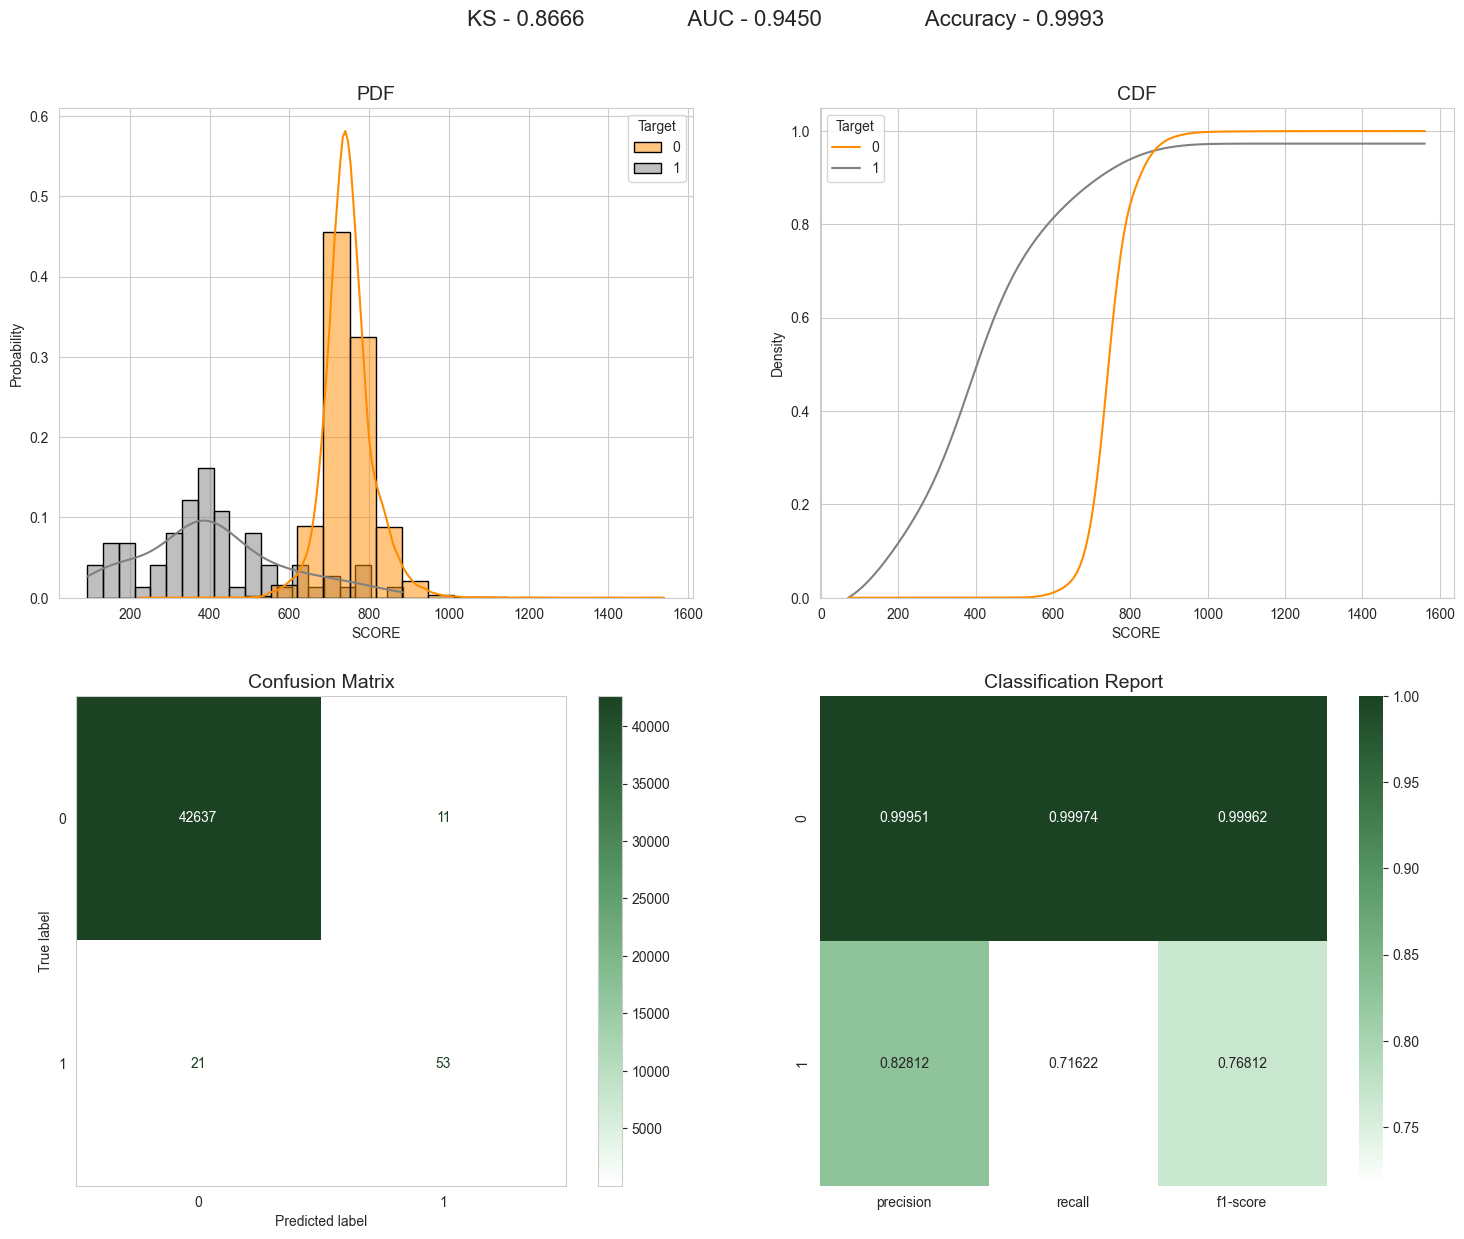

In [25]:
from DSHelperFunctions import classification_predictive_power
classification_predictive_power(y_test, pred_test, scoring_func = lambda x: 487.123 + 28.8539 * np.log((1 - x) / x))

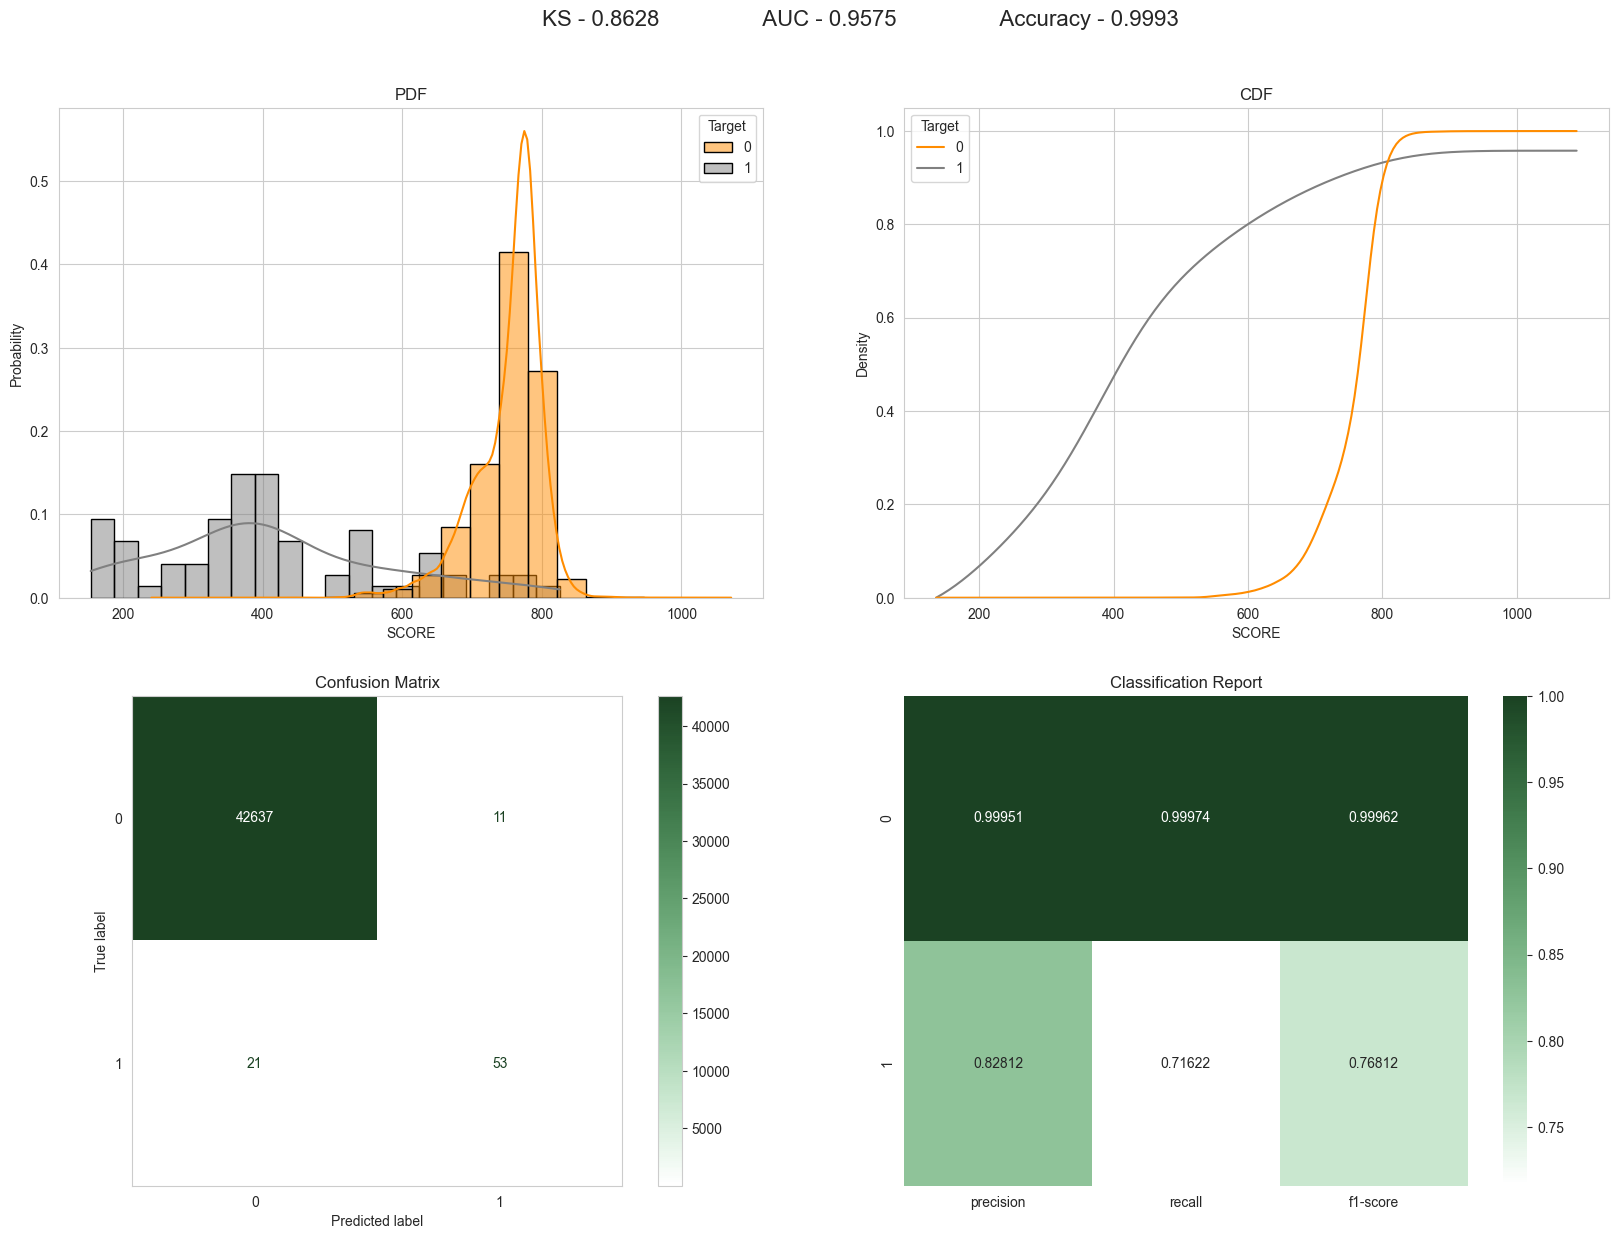